In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PyCO2SYS

In [2]:
#pip install PyCO2SYS

   ---------------------------------------- 0.0/110.5 kB ? eta -:--:--
   ------- ------------------------------- 20.5/110.5 kB 682.7 kB/s eta 0:00:01
   ------------------------- ------------- 71.7/110.5 kB 787.7 kB/s eta 0:00:01
   -------------------------------------- 110.5/110.5 kB 919.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/49.3 kB ? eta -:--:--
   ---------------------------------------- 49.3/49.3 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/491.3 kB ? eta -:--:--
   ------------------------- -------------- 307.2/491.3 kB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 491.3/491.3 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
print(PyCO2SYS.__version__)

1.8.3.1


In [4]:
df = pd.read_csv('MWRA.csv')
df.columns

Index(['STUDY_ID', 'EVENT_ID', 'STAT_ID', 'ORDERED_DEPTH_CODE', 'SAMPLE_ID',
       'SAMPLE_DEPTH_TOP', 'SAMPLE_DEPTH_BOTTOM', 'LATITUDE', 'LONGITUDE',
       'PROF_DATE_TIME_LOCAL', 'SAMPLE_DEPTH_CODE', 'DEPTH (m)',
       'CONDTVY (mS/cm)', 'DISS_OXYGEN (mg/L)', 'FLUORESCENCE (ug/L)',
       'FLU_RAW (ug/L)', 'PCT_SAT (PCT)', 'pH ()', 'VAL_QUAL', 'SAL (PSU)',
       'SIGMA_T ()', 'TEMP (C)', 'TRANS (m-1)', 'Station_D', 'Air Irradiance',
       'Water Irradiance', 'TA in (mmol/kgSW)', 'TCO2 in (mmol/kgSW)',
       't(oC) out', 'P (dbars) out', 'pH out', 'fCO2 out (matm)',
       'pCO2 out (matm)', 'HCO3 out (mmol/kgSW)', 'CO3 out (mmol/kgSW)',
       'CO2 out (mmol/kgSW)', 'B Alk out (mmol/kgSW)', 'OH out (mmol/kgSW)',
       'P Alk out (mmol/kgSW)', 'Si Alk out (mmol/kgSW) ', 'Revelle out',
       'WCa out', 'WAr out', 'xCO2 out (dry at 1 atm) (ppm)',
       'Field Replicate', 'VINDTA Sample Name', 'Sampled Bottle Name',
       'Sampling Date', 'Sampling Depth', 'Salinity - Carolina'

In [6]:
df = pd.read_csv('MWRA.csv')
df = df[df['VAL_QUAL'] != -1] #excluding suspicious pH values

ph_var = 'pH ()' # ph out
df = df[['STAT_ID','DEPTH (m)', 'TEMP (C)', 'SAL (PSU)', 'TA in (mmol/kgSW)', ph_var, 'WAr out','TCO2 in (mmol/kgSW)']]
df.columns = ['Station', 'Depth','Temperature','Salinity', 'TA', 'pH', 'Ar', 'DIC']

df = df[df['Station'] != 'HAR']
df = df[df['Station'] != 'NFAL']
df = df[df['Station'] != 'POC']


df.head()

,Station,Depth,Temperature,Salinity,TA,pH,Ar,DIC
0,F13,1.61,3.386,32.52,NaN,8.040,NaN,NaN
1,F13,5.63,3.425,32.52,NaN,8.027,NaN,NaN
2,F13,11.00,3.592,32.55,NaN,8.001,NaN,NaN
3,F13,16.75,3.690,32.57,NaN,7.973,NaN,NaN
4,F13,22.79,3.794,32.59,NaN,7.922,NaN,NaN


In [7]:
print(len(df[~df['DIC'].isna()]))
print(len(df[~df['pH'].isna()]))
print(len(df[~df['TA'].isna()]))
print(len(df[~df['Ar'].isna()]))

481
3405
481
481


0.007402832185710612

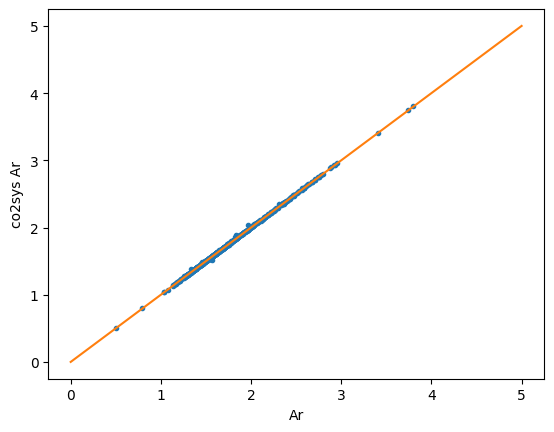

In [8]:
# TO DO: need to translate pH to be lab temperature!

test = df.copy()
test = test[~test['Ar'].isna()]
test = test[~test['DIC'].isna()]
test = test[~test['TA'].isna()]

co2sys = PyCO2SYS.sys(
    par1_type=1,  # Total Alkalinity input 1
    par1=test['TA'],
    par2_type=2,  # DIC input 2
    par2=test['DIC'],
    salinity=test['Salinity'],  # practical salinity (default 35)

    temperature = 25,  # temperature at which par1 and par2 arguments are provided in °C (default 25 °C)
    pressure = 0,   # water pressure at which par1 and par2 arguments are provided in dbar (default 0 dbar)
    temperature_out = test['Temperature'], # temperature at which results will be calculated in °C 
    pressure_out = test['Depth'], # water pressure at which results will be calculated in dbar
    
    opt_pH_scale = 4, # NBS 4
    opt_k_carbonic = 1, # Roy et al 1993 1
    opt_k_bisulfate = 1, # Dickson et al 1990 1
    opt_total_borate = 2, # Lee et al 2010 2
    opt_k_fluoride = 1 # Dickson and Riley 1979 1
)

Ar_pred_DIC = co2sys["saturation_aragonite_out"]

plt.plot(test['Ar'], Ar_pred_DIC, '.')
plt.plot(np.arange(0,6))
plt.xlabel('Ar')
plt.ylabel('co2sys Ar')

np.sqrt(np.mean(np.square(test['Ar']-Ar_pred_DIC)))


0.46861948532378767

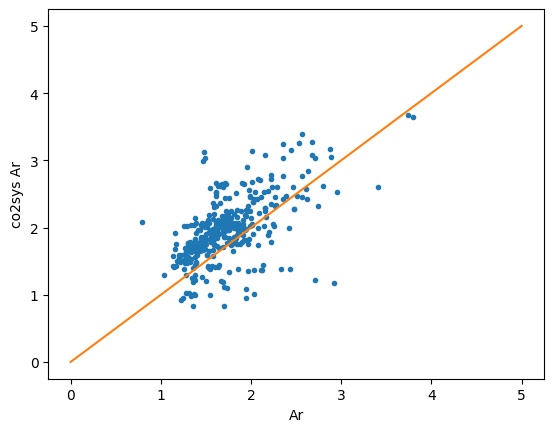

In [11]:
# TO DO: need to translate pH to be lab temperature!

test = df.copy()
test = test[~test['pH'].isna()]
test = test[~test['TA'].isna()]
test = test[~test['Ar'].isna()]

co2sys = PyCO2SYS.sys(
    par1_type=1,  # Total Alkalinity input 1
    par1=test['TA'],
    par2_type=3,  # pH input 3
    par2=test['pH'],
    salinity=test['Salinity'],  # practical salinity (default 35)

    #temperature = 25,  # temperature at which par1 and par2 arguments are provided in °C (default 25 °C)
    temperature = test['Temperature'], 
    pressure = 0,   # water pressure at which par1 and par2 arguments are provided in dbar (default 0 dbar)
    temperature_out = test['Temperature'], # temperature at which results will be calculated in °C 
    pressure_out = test['Depth'], # water pressure at which results will be calculated in dbar
    
    opt_pH_scale = 4, # NBS 4
    opt_k_carbonic = 1, # Roy et al 1993 1
    opt_k_bisulfate = 1, # Dickson et al 1990 1
    opt_total_borate = 2, # Lee et al 2010 2
    opt_k_fluoride = 1 # Dickson and Riley 1979 1
)

Ar_pred_pH = co2sys["saturation_aragonite_out"]

plt.plot(test['Ar'], Ar_pred_pH, '.')
plt.plot(np.arange(0,6))
plt.xlabel('Ar')
plt.ylabel('co2sys Ar')

np.sqrt(np.mean(np.square(test['Ar']-Ar_pred_pH)))
